# Hansard Data Exploration and Cleaning

This notebook explores a subset of the Canadian Hansard parliamentary debate dataset available at https://www.lipad.ca/data/. The pandas dataframe contains combines CSV transcripts of Parliamentary sessions from January 2016 to June 2019, roughly the period following the last federal election.

In [1]:
# Import modules
import pandas as pd
import numpy as np
from gensim.summarization.summarizer import summarize
import matplotlib.pyplot as plt
import re, math
from collections import Counter
import itertools
import sys
sys.path.append('../scripts/')
import hansard_funcs as hf


In [2]:
# Load the data
df_original = pd.read_pickle('../../data/hansard.pkl') # Version to keep as-is for later use
df = pd.read_pickle('../../data/hansard.pkl') # Version to be cleaned


In [38]:
# Inspect available columns
df.head(3)
len(df)

127976

In [4]:
# The rest of the notebook uses functions that are defined in ../scripts/hansard_funcs.py

# How many unique speakers spoke during the debates?
hf.get_num_unique_speakers(df)

# Overwrite NaNs with spaces
df['speakername'].fillna(' ', inplace=True)

# Remove all information in speakername column that is not first or last name
text_to_remove = ['^Hon.', 'Mr. ', 'Mrs. ', 'Ms. ', 'Miss. ', '\s+\(.+\)', '^\s+']
df['speakername'] = df['speakername'].replace(text_to_remove, '', regex=True)

# Remove additional anomalies
df['speakername'] = df['speakername'].replace('\s+\(.+\)*', '', regex=True) # Parantheses containing a speaker's riding and/or party
df['speakername'] = df['speakername'].replace('The ', '', regex=True) # 
df['speakername'] = df['speakername'].replace('Speaker Speaker', 'Speaker', regex=True)
df['speakername'] = df['speakername'].replace(['Soem', 'Som', 'Somee+'], 'Some', regex=True) # Typos in transcription of 'some'
df['speakername'] = df['speakername'].replace('Hon\s', 'Hon.', regex=True)
df['speakername'] = df['speakername'].replace('hon\s', 'hon.', regex=True)
df['speakername'] = df['speakername'].replace('An hon. members', 'An hon. member', regex=True)
df['speakername'] = df['speakername'].replace('^members$', 'Members', regex=True)

# After additional cleaning, how many unique speakers spoke during the debates?
hf.get_num_unique_speakers(df)

# Check for rows that contain only one name
is_single_word = df['speakername'].str.contains('^\w[\w]*$', regex=True)
is_not_speaker = ~df['speakername'].str.contains('^Speaker$', regex=True)
is_not_members = ~df['speakername'].str.contains('^Members$', regex=True)
bool_ind = is_single_word & is_not_speaker & is_not_members
standalone_names = df["speakername"][bool_ind[bool_ind].index]
print('Speakers with only one name listed (i.e. ambiguous cases):\n%s'% standalone_names)

# Store standalone names in python dict
standalone_names_dict = standalone_names.to_dict()


Number of unique speakers: 534
Number of unique speakers: 382
Speakers with only one name listed (i.e. ambiguous cases):
22982       Miller
24266    Warkentin
29504    MacKenzie
40377     Eglinski
45615     McCauley
46342    MacKenzie
Name: speakername, dtype: object


In [5]:
# Inspect row with standalone 'Miller' in original dataframe
key = hf.get_key_from_value(standalone_names_dict, 'Miller')
hf.inspect_row(df_original, key)



Inspecting row 22982:
basepk                                                   4.68097e+06
hid                                    ca.proc.d.2016-09-27.p4477043
speechdate                                                2016-09-27
pid                                                              NaN
opid                                                             NaN
speakeroldname                                                   NaN
speakerposition                                                  NaN
maintopic                                        Routine Proceedings
subtopic                                Questions on the Order Paper
subsubtopic                                         Question No. 258
speechtext          With regard to relocation costs for exempt st...
speakerparty                                                     NaN
speakerriding                                                    NaN
speakername                       Mr. Miller (Bruce—Grey—Owen Sound)
speakerurl 

In [6]:
# Show all related names
hf.show_names_containing(df, 'Miller')



Unique occurences of Miller:
['Larry Miller' 'Marc Miller' 'Miller']



In [7]:
# Raw data shows standalone Miller's riding is Bruce-Grey-Owen-Sound - cross-reference with other Millers
# Check entries for Larry Miller
hf.inspect_speaker(df, 'Larry Miller')



Inspecting speaker Larry Miller:
           basepk                             hid  speechdate  \
3893    4652499.0   ca.proc.d.2016-02-22.17093.56  2016-02-22   
3895    4652501.0   ca.proc.d.2016-02-22.17093.58  2016-02-22   
3897    4652503.0   ca.proc.d.2016-02-22.17093.60  2016-02-22   
3899    4652505.0   ca.proc.d.2016-02-22.17093.62  2016-02-22   
3939    4652545.0  ca.proc.d.2016-02-22.17093.102  2016-02-22   
...           ...                             ...         ...   
116692  4775053.0   ca.proc.d.2019-04-09.10562537  2019-04-09   
123922  4782287.0   ca.proc.d.2019-06-04.10676419  2019-06-04   
124054  4782419.0   ca.proc.d.2019-06-04.10677224  2019-06-04   
124059  4782424.0   ca.proc.d.2019-06-04.10677443  2019-06-04   
124835  4783200.0   ca.proc.d.2019-06-06.10686706  2019-06-06   

                                         pid      opid  \
3893    d5a197ec-6694-4a63-b918-f7c55df7b7c2     202.0   
3895    d5a197ec-6694-4a63-b918-f7c55df7b7c2     202.0   
3897    d5a

In [8]:
# Larry Miller's riding is Bruce-Grey-Owen-Sound, same as standalone Miller
hf.overwrite_speaker(df, 'Miller', 'Larry Miller', key)


Row after overwriting Miller with Larry Miller:
basepk                                                   4.68097e+06
hid                                    ca.proc.d.2016-09-27.p4477043
speechdate                                                2016-09-27
pid                                                              NaN
opid                                                             NaN
speakeroldname                                                   NaN
speakerposition                                                  NaN
maintopic                                        Routine Proceedings
subtopic                                Questions on the Order Paper
subsubtopic                                         Question No. 258
speechtext          With regard to relocation costs for exempt st...
speakerparty                                                     NaN
speakerriding                                                    NaN
speakername                                            

In [9]:
# Inspect row with standalone 'Warkentin' in original dataframe
key = hf.get_key_from_value(standalone_names_dict, 'Warkentin')
hf.inspect_row(df_original, key)



Inspecting row 24266:
basepk                               4.68225e+06
hid                ca.proc.d.2016-10-04.p4499228
speechdate                            2016-10-04
pid                                          NaN
opid                                         NaN
speakeroldname                               NaN
speakerposition                              NaN
maintopic                         Oral Questions
subtopic                      Indigenous Affairs
subsubtopic                                  NaN
speechtext                             Minister?
speakerparty                                 NaN
speakerriding                                NaN
speakername                        Mr. Warkentin
speakerurl                                   NaN
Unnamed: 0                                   NaN
Name: 24266, dtype: object



In [10]:
# Show all related names
hf.show_names_containing(df, 'Warkentin')



Unique occurences of Warkentin:
['Chris Warkentin' 'Warkentin']



In [11]:
# Check entries for Chris Warkentin
hf.inspect_speaker(df, 'Chris Warkentin')



Inspecting speaker Chris Warkentin:
           basepk                             hid  speechdate  \
163     4648769.0  ca.proc.d.2016-01-25.17043.163  2016-01-25   
544     4649150.0  ca.proc.d.2016-01-26.17045.196  2016-01-26   
731     4649337.0   ca.proc.d.2016-01-27.17047.79  2016-01-27   
733     4649339.0   ca.proc.d.2016-01-27.17047.81  2016-01-27   
4924    4653530.0  ca.proc.d.2016-02-25.17111.213  2016-02-25   
...           ...                             ...         ...   
113518  4771879.0   ca.proc.d.2019-02-28.10515675  2019-02-28   
114693  4773054.0   ca.proc.d.2019-03-19.10533669  2019-03-19   
122373  4780737.0   ca.proc.d.2019-05-28.10655768  2019-05-28   
126418  4784784.0   ca.proc.d.2019-06-14.10711226  2019-06-14   
126515  4784881.0   ca.proc.d.2019-06-14.p5993465  2019-06-14   

                                         pid      opid  \
163     ebbfc235-08c5-44f8-8c22-a60c671db398     461.0   
544     ebbfc235-08c5-44f8-8c22-a60c671db398     461.0   
731     

In [12]:
# Standalone Warkentin seems to be Chris Warkentin
hf.overwrite_speaker(df, 'Warkentin', 'Chris Warkentin', key)


Row after overwriting Warkentin with Chris Warkentin:
basepk                               4.68225e+06
hid                ca.proc.d.2016-10-04.p4499228
speechdate                            2016-10-04
pid                                          NaN
opid                                         NaN
speakeroldname                               NaN
speakerposition                              NaN
maintopic                         Oral Questions
subtopic                      Indigenous Affairs
subsubtopic                                  NaN
speechtext                             Minister?
speakerparty                                 NaN
speakerriding                                NaN
speakername                      Chris Warkentin
speakerurl                                   NaN
Unnamed: 0                                   NaN
Name: 24266, dtype: object



In [13]:
# Inspect row with standalone 'MacKenzie' in original dataframe
key = hf.get_key_from_value(standalone_names_dict, 'MacKenzie')
hf.inspect_row(df_original, key)



Inspecting row 29504:
basepk                                                   4.68729e+06
hid                                    ca.proc.d.2016-11-04.p4610244
speechdate                                                2016-11-04
pid                                                              NaN
opid                                                             NaN
speakeroldname                                                   NaN
speakerposition                                                  NaN
maintopic                                        Routine Proceedings
subtopic                                Questions on the Order Paper
subsubtopic                                         Question No. 476
speechtext          With regard to the government’s decision to j...
speakerparty                                                     NaN
speakerriding                                                    NaN
speakername                                   Mr. MacKenzie (Oxford)
speakerurl 

In [14]:
# Show all related names
hf.show_names_containing(df, 'MacKenzie')



Unique occurences of MacKenzie:
['Dave MacKenzie' 'MacKenzie']



In [15]:
# Check entries for Dave MacKenzie
hf.inspect_speaker(df, 'Dave MacKenzie')



Inspecting speaker Dave MacKenzie:
           basepk                             hid  speechdate  \
5571    4654177.0  ca.proc.d.2016-03-07.17151.290  2016-03-07   
5573    4654179.0  ca.proc.d.2016-03-07.17151.292  2016-03-07   
8908    4657514.0  ca.proc.d.2016-04-14.17222.121  2016-04-14   
21199   4679501.0   ca.proc.d.2016-09-19.p4466947  2016-09-19   
23179   4681165.0    ca.proc.d.2016-09-28.9082584  2016-09-28   
...           ...                             ...         ...   
111812  4770173.0   ca.proc.d.2019-02-19.10491338  2019-02-19   
116712  4775073.0   ca.proc.d.2019-04-09.p5854978  2019-04-09   
119657  4778018.0   ca.proc.d.2019-05-06.10600456  2019-05-06   
126504  4784870.0   ca.proc.d.2019-06-14.p5993454  2019-06-14   
126828  4785194.0   ca.proc.d.2019-06-17.p5996853  2019-06-17   

                                         pid      opid  \
5571    f16cf9dc-8300-44a4-8a4e-22df5fec17c8     178.0   
5573    f16cf9dc-8300-44a4-8a4e-22df5fec17c8     178.0   
8908    f

In [16]:
# Riding (Oxford) overlaps
# Standalone MacKenzie seems to be Dave MacKenzie
hf.overwrite_speaker(df, 'MacKenzie', 'Dave MacKenzie', key)


Row after overwriting MacKenzie with Dave MacKenzie:
basepk                                                   4.68729e+06
hid                                    ca.proc.d.2016-11-04.p4610244
speechdate                                                2016-11-04
pid                                                              NaN
opid                                                             NaN
speakeroldname                                                   NaN
speakerposition                                                  NaN
maintopic                                        Routine Proceedings
subtopic                                Questions on the Order Paper
subsubtopic                                         Question No. 476
speechtext          With regard to the government’s decision to j...
speakerparty                                                     NaN
speakerriding                                                    NaN
speakername                                       

In [17]:
# Inspect row with standalone 'Eglinski' in original dataframe
key = hf.get_key_from_value(standalone_names_dict, 'Eglinski')
hf.inspect_row(df_original, key)



Inspecting row 40377:
basepk                                                   4.69868e+06
hid                                    ca.proc.d.2017-02-15.p4750367
speechdate                                                2017-02-15
pid                                                              NaN
opid                                                             NaN
speakeroldname                                                   NaN
speakerposition                                                  NaN
maintopic                                        Routine Proceedings
subtopic                      Questions Passed as Orders for Returns
subsubtopic                                         Question No. 827
speechtext          With regard to the Prime Minister’s trip to C...
speakerparty                                                     NaN
speakerriding                                                    NaN
speakername                                Mr. Eglinski (Yellowhead)
speakerurl 

In [18]:
# Show all related names
hf.show_names_containing(df, 'Eglinski')



Unique occurences of Eglinski:
['Jim Eglinski' 'Eglinski']



In [19]:
# Check entries for Jim Eglinski
hf.inspect_speaker(df, 'Jim Eglinski')



Inspecting speaker Jim Eglinski:
           basepk                             hid  speechdate  \
203     4648809.0  ca.proc.d.2016-01-25.17043.203  2016-01-25   
1208    4649814.0   ca.proc.d.2016-01-29.17049.21  2016-01-29   
3884    4652490.0   ca.proc.d.2016-02-22.17093.47  2016-02-22   
3886    4652492.0   ca.proc.d.2016-02-22.17093.49  2016-02-22   
3888    4652494.0   ca.proc.d.2016-02-22.17093.51  2016-02-22   
...           ...                             ...         ...   
124580  4782945.0   ca.proc.d.2019-06-06.10682936  2019-06-06   
124581  4782946.0   ca.proc.d.2019-06-06.10683289  2019-06-06   
124845  4783210.0   ca.proc.d.2019-06-06.10686730  2019-06-06   
124847  4783212.0   ca.proc.d.2019-06-06.10686778  2019-06-06   
124849  4783214.0   ca.proc.d.2019-06-06.10686787  2019-06-06   

                                         pid      opid  \
203     e849cb7a-82f0-49eb-aea4-573c06169a5d    9294.0   
1208    e849cb7a-82f0-49eb-aea4-573c06169a5d    9294.0   
3884    e84

In [20]:
# Riding (Yellowhead) overlaps
# Standalone Eglinski seems to be Jim Eglinski
hf.overwrite_speaker(df, 'Eglinski', 'Jim Eglinski', key)


Row after overwriting Eglinski with Jim Eglinski:
basepk                                                   4.69868e+06
hid                                    ca.proc.d.2017-02-15.p4750367
speechdate                                                2017-02-15
pid                                                              NaN
opid                                                             NaN
speakeroldname                                                   NaN
speakerposition                                                  NaN
maintopic                                        Routine Proceedings
subtopic                      Questions Passed as Orders for Returns
subsubtopic                                         Question No. 827
speechtext          With regard to the Prime Minister’s trip to C...
speakerparty                                                     NaN
speakerriding                                                    NaN
speakername                                          

In [21]:
# Inspect row with standalone 'McCauley' in original dataframe
key = hf.get_key_from_value(standalone_names_dict, 'McCauley')
hf.inspect_row(df_original, key)



Inspecting row 45615:
basepk                                                   4.70397e+06
hid                                    ca.proc.d.2017-04-03.p4823722
speechdate                                                2017-04-03
pid                                                              NaN
opid                                                             NaN
speakeroldname                                                   NaN
speakerposition                                                  NaN
maintopic                                        Routine Proceedings
subtopic                       Questions Passed as Orders for Return
subsubtopic                                         Question No. 843
speechtext          With regard to public service training for th...
speakerparty                                                     NaN
speakerriding                                                    NaN
speakername                             Mr. McCauley (Edmonton West)
speakerurl 

In [22]:
# Show all related names
hf.show_names_containing(df, 'McCauley')



Unique occurences of McCauley:
['Kelly McCauley' 'McCauley']



In [23]:
# Check entries for Kelly McCauley
hf.inspect_speaker(df, 'Kelly McCauley')



Inspecting speaker Kelly McCauley:
           basepk                             hid  speechdate  \
789     4649395.0  ca.proc.d.2016-01-27.17047.137  2016-01-27   
791     4649397.0  ca.proc.d.2016-01-27.17047.139  2016-01-27   
793     4649399.0  ca.proc.d.2016-01-27.17047.141  2016-01-27   
795     4649401.0  ca.proc.d.2016-01-27.17047.143  2016-01-27   
962     4649568.0   ca.proc.d.2016-01-28.17048.95  2016-01-28   
...           ...                             ...         ...   
126208  4784574.0   ca.proc.d.2019-06-13.10710203  2019-06-13   
126772  4785138.0   ca.proc.d.2019-06-17.10712742  2019-06-17   
127529  4785895.0   ca.proc.d.2019-06-18.10718169  2019-06-18   
127603  4785969.0   ca.proc.d.2019-06-18.10718356  2019-06-18   
127649  4786015.0   ca.proc.d.2019-06-18.10718443  2019-06-18   

                                         pid      opid  \
789     62c4052f-dd41-418a-9b5b-1715c0baa84d    9445.0   
791     62c4052f-dd41-418a-9b5b-1715c0baa84d    9445.0   
793     6

In [24]:
# Riding (Edmonston West) overlaps
# Standalone McCauley seems to be Kelly McCauley
hf.overwrite_speaker(df, 'McCauley', 'Kelly McCauley', key)


Row after overwriting McCauley with Kelly McCauley:
basepk                                                   4.70397e+06
hid                                    ca.proc.d.2017-04-03.p4823722
speechdate                                                2017-04-03
pid                                                              NaN
opid                                                             NaN
speakeroldname                                                   NaN
speakerposition                                                  NaN
maintopic                                        Routine Proceedings
subtopic                       Questions Passed as Orders for Return
subsubtopic                                         Question No. 843
speechtext          With regard to public service training for th...
speakerparty                                                     NaN
speakerriding                                                    NaN
speakername                                        

In [25]:
# Show speakers with periods in their names
df[df['speakername'].str.contains('\.', regex=True)]['speakername'].unique()


array(['Some hon. members', 'Harjit S. Sajjan', 'An hon. member',
       'Some hon.members', 'Some hon. member', 'An. hon. member',
       'Don. Davies', 'John. Barlow', 'Some. hon. members'], dtype=object)

In [26]:
# Merge speaker
# Don. Davies -> Don Davies
key = hf.get_key_from_value(df['speakername'], 'Don. Davies')
df.loc[key]
hf.overwrite_speaker(df, 'Don. Davies', 'Don Davies', key)


Row after overwriting Don. Davies with Don Davies:
basepk                                        4.68794e+06
hid                         ca.proc.d.2016-11-14.p4635200
speechdate                                     2016-11-14
pid                                                   NaN
opid                                                  NaN
speakeroldname                                        NaN
speakerposition                                       NaN
maintopic                               Government Orders
subtopic           Budget Implementation Act, 2016, No. 2
subsubtopic                                           NaN
speechtext                        South Korea and Jordan.
speakerparty                                          NaN
speakerriding                                         NaN
speakername                                    Don Davies
speakerurl                                            NaN
Unnamed: 0                                            NaN
Name: 30159, dtype: o

In [27]:
# Merge speaker
# John. Barlow -> John Barlow
key = hf.get_key_from_value(df['speakername'], 'John. Barlow')
df.loc[key]
hf.overwrite_speaker(df, 'John. Barlow', 'John Barlow', key)


Row after overwriting John. Barlow with John Barlow:
basepk                                                    4.7176e+06
hid                                    ca.proc.d.2017-06-20.p4971431
speechdate                                                2017-06-20
pid                                                              NaN
opid                                                             NaN
speakeroldname                                                   NaN
speakerposition                                                  NaN
maintopic                                          Government Orders
subtopic                                              Statistics Act
subsubtopic                                                      NaN
speechtext          You should change you talking points. You sho...
speakerparty                                                     NaN
speakerriding                                                    NaN
speakername                                       

In [28]:
# Save to pkl file
df.to_pickle('../../data/hansard_cleaned.pkl')

In [29]:
# For upcoming plots, limit unique speakers to individuals
unique_speakers = df.speakername.unique()
exclude_list = [
'',
'Members',
'Deputy Speaker',
'Some hon. members',
'Some hon.members',
'Some hon. member',
'An. hon. member',
'Speaker?',
'Some. hon. members',
'Acting Deputy Speaker',
'Acting Speaker'
]
unique_speakers = [x for x in unique_speakers if x not in exclude_list]


In [30]:
# Count words per speech
num_words = []
for i in range(len(df['speechtext'])):
    num_words.append(len(df['speechtext'][i].split(' ')))


(array([1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05, 1.e+07, 1.e+09]),
 <a list of 7 Text yticklabel objects>)

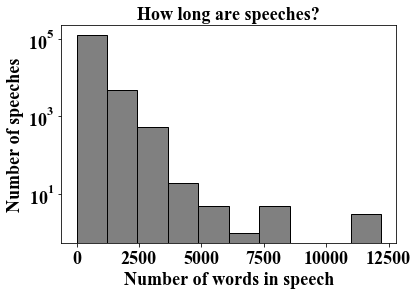

In [31]:
# Plot histogram of speech lengths
fontsize_major = 18
fontsize_minor = 18
fontname = 'Times New Roman'

plt.hist(num_words, edgecolor = 'black', color='grey')
plt.yscale('log', nonposy='clip')
plt.xlabel('Number of words in speech', fontsize=fontsize_minor, fontname=fontname)
plt.ylabel('Number of speeches', fontsize=fontsize_minor, fontname=fontname)
plt.title('How long are speeches?', fontsize=fontsize_major, fontname=fontname)
plt.tick_params(axis='both', which='major', labelsize=fontsize_minor)
plt.xticks(fontname=fontname)
plt.yticks(fontname=fontname)


In [32]:
# Show speakers with speeches longer than k
k = 12000
[df.loc[i] for i in range(len(num_words)) if num_words[i] > k]


[basepk                                                   4.76702e+06
 hid                                    ca.proc.d.2019-01-28.p5752334
 speechdate                                                2019-01-28
 pid                             b6850f16-57dc-486c-b5bb-0fd191022af4
 opid                                                          216935
 speakeroldname                                    Mr. Garnett Genuis
 speakerposition                                                  NaN
 maintopic                                          Government Orders
 subtopic                         Federal Sustainable Development Act
 subsubtopic                                                      NaN
 speechtext          It was Disraeli. Maybe Margaret Thatcher said...
 speakerparty                                            Conservative
 speakerriding                        Sherwood Park—Fort Saskatchewan
 speakername                                           Garnett Genuis
 speakerurl         

In [33]:
# Count speeches per speaker
num_speeches = []
for i in range(len(unique_speakers)):
    num_speeches.append(len(df[df['speakername'] == unique_speakers[i]]['speechtext']))


(array([  0., 100., 200., 300., 400.]), <a list of 5 Text yticklabel objects>)

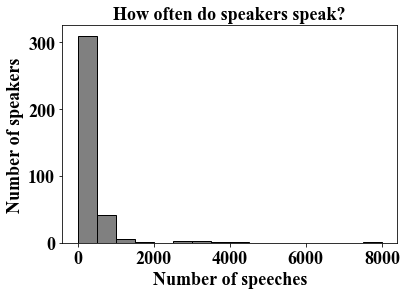

In [37]:
# Plot histogram showing number of times speakers speak
plt.hist(num_speeches, edgecolor='black', color='grey', bins=[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000])
plt.xlabel('Number of speeches', fontsize=fontsize_minor, fontname=fontname)
plt.ylabel('Number of speakers', fontsize=fontsize_minor, fontname=fontname)
plt.title('How often do speakers speak?', fontsize=fontsize_major, fontname=fontname)
plt.tick_params(axis='both', which='major', labelsize=fontsize_minor)
plt.xticks(fontname=fontname)
plt.yticks(fontname=fontname)


In [35]:
# Show speakers who have spoken more than k times
k = 2000
[unique_speakers[i] for i in range(len(num_speeches)) if num_speeches[i] > k]


['Kevin Lamoureux',
 'Bruce Stanton',
 'Geoff Regan',
 'Justin Trudeau',
 'Carol Hughes',
 'Anthony Rota']

In [36]:
# Show number of times that a specific speaker has spoken
specific_speaker = 'Geoff Regan'
num_speeches[unique_speakers.index(specific_speaker)]


7563

Makes sense that Geoff Regan (speaker of the house) has given plenty of speeches.

After inspecting a few ambiguous names manually, seems possible to automate the process going forward.
e.g. When a name is ambiguous (for example, Mr. Miller), look for parantheses containing a riding and cross-reference against the speakerriding column for Marc Miller and Larry Miller